---

<h1><center><br> Gradient descent and <br> Stochastic Gradient Descent </center></h1>

---

In [1]:
result={}

# Introduction

We wish to model a process with scalar input $X$ and scalar output $Y$. Both of these are real-valued random variables; their sample spaces are the real line. The joint distribution of $X$ and $Y$ is given as:
\begin{align*}
X &\sim \mathcal{U}(0,1) \\
Y|X\!=\!x &\sim \mathcal{N}( \theta_0 + \theta_1 x ,\sigma^2_\epsilon)
\end{align*}
This definition of $Y|X\!=\!x$ is equivalent to,
\begin{equation*}
Y = \theta_0 + \theta_1 X + \epsilon
\end{equation*}
with $\epsilon\sim\mathcal{N}(0,\sigma^2_\epsilon)$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats as stats

# 1. Sampling the joint distribution

We will first construct a synthetic dataset by sampling  from $(X,Y)$. 

## (1a)

Write a function called `sampleXY` that produces a dataset $\{(x_n,y_n)\}_N$ of iid samples from $(X,Y)$, given arguments $N$, $\theta_0$, $\theta_1$, and $\sigma^2_\epsilon$. The output of this function should be a numpy array with shape = $(N,2)$. 

In [3]:
def sampleXY(N, theta0, theta1, sigma2_eps):
    
    samples = np.empty([N,2])
    X = np.empty([N,1])
    Y = np.empty([N,1])
    
    eps = stats.norm.rvs(loc = 0, scale = np.sqrt(sigma2_eps), size =N)
    X = stats.uniform.rvs(loc = 0, scale = 1, size = N)
    samples[:,0] = X
    
    Y = theta0 + theta1*X + eps
    samples[:,1] = Y
    
    return samples

In [4]:
N = 40
theta0 = 0.2
theta1 = -0.4
sigma_eps = 0.0049
XYsamp = sampleXY(N, theta0, theta1, sigma_eps)

Run `sampleXY` with $N\!=\!40$, $\theta_0\!=\!0.2$, $\theta_1\!=\!-0.4$, and $\sigma^2_\epsilon\!=\!0.0049$ and assign the result to the variable `XYsamp`. Create a plot showing the line $y=\theta_0 + \theta_1 x$, overlaid with a scatter plot of `XYsamp`. 

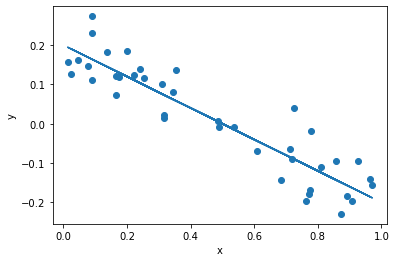

In [5]:
fig1 = plt.figure()
plt.scatter(XYsamp[:,0],XYsamp[:,1])
plt.plot(XYsamp[:,0], theta0 + theta1*XYsamp[:,0])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We will now overwrite the sampled data with another dataset contained in the file `Data.pickle`. This is so the results are predictable.

In [6]:
with open('./Data.pickle', 'rb') as file:
    XYsamp = pickle.load(file)

# 2. Gradient descent

We will now write an iterative numerical algorithm for solving the least squares problem. We take the objective function of the problem to be:
\begin{equation*}
J(\hat\theta_0,\hat\theta_1) = \frac{1}{N} \sum_{n=1}^{N} \left( \hat\theta_0 + \hat \theta_1 \:x_n - y_n \right)^2
\end{equation*}

## (2a)

Write a function called `nablaJ` that takes `XYsamp`, $\hat\theta_0$, and $\hat\theta_1$ as inputs, and returns the gradient as a numpy array of length 2.

In [7]:
def nablaJ(XYsamp, theta0, theta1):
    N = XYsamp.shape[0]
    
    grad = np.empty([1,2])
    nablaj0 = 2*(theta0 + theta1*XYsamp[:,0]-XYsamp[:,1]) 
    nablaj1 = 2*(theta0 + theta1*XYsamp[:,0]-XYsamp[:,1])*XYsamp[:,0]
    grad[0,0] = np.sum(nablaj0)/N
    grad[0,1] = np.sum(nablaj1)/N
    
    return grad

## (2b)

Write a function called `gradient_descent` that executes the gradient descent algorithm. This function should take as input 

+ The dataset `XYsamp`
+ the total number of steps to take $K$
+ the step size $\gamma$
+ the initial condition Theta0 as a numpy array of length 2. 

It should return the trajectory as a with shape = `(K,2)`.

In [8]:
def gradient_descent(XYsamp,K,gamma,Theta0):
    M = XYsamp.shape[1]
    
    Theta = np.empty((K, M))
    
    # Initial condition
    Theta[0] = Theta0
    
    # K steps of gradient descent (discard the final state according to Piazza)
    for i in range(K-1):
        Theta[i+1] = Theta[i] - gamma*nablaJ(XYsamp, Theta[i, 0], Theta[i, 1])

    return Theta

## (2c)

Complete the `run_gd_on_grid(theta0_grid,theta1_grid,K,gamma)`. This function takes as input
+ `theta0_grid` and `theta1_grid`. These are a 5x5 grid of values of $\hat\theta_0$ and $\hat\theta_1$. 
+ `K`: the number of steps to take, and
+ `gamma`: the step size. 

The function should return a numpy array with shape (5,5,K,2), where the (i,j,:,:) is a (K,2) trajectory of parameter values. 

Run the function with $K=200$, $\gamma=0.2$.

In [9]:
def make_grid(gridN):
    theta_0_array = np.linspace(-1,1,gridN)
    theta_1_array = np.linspace(-1,1,gridN)
    return  np.meshgrid(theta_0_array,theta_1_array)

gridN = 5
theta0_grid,theta1_grid = make_grid(gridN)

In [10]:
def run_gd_on_grid(theta0_grid,theta1_grid,K,gamma):
    
    M = XYsamp.shape[1]
    
    trajectories = np.empty((gridN, gridN, K, M))
    
    # For each grid point (i,j), compute the trajectory
    for i in range(gridN): 
        for j in range(gridN): 
            trajectories[i, j] = gradient_descent(XYsamp, K, gamma, 
                                                np.array([theta0_grid[i, j],theta1_grid[i, j]]))
    
    return trajectories

In [11]:
result['grid_3c'] = run_gd_on_grid(theta0_grid,theta1_grid,K=200,gamma=0.2)

## (2d)

Write a function that plots the error vectors for each of the 25 trajectories in a single plot. The error for each trajectory is an array of length 200, with the $k$'th element computed as:
\begin{equation*}
e_k := \sqrt{ (\hat\theta_{0,k}-\theta_0)^2 + (\hat\theta_{1,k}-\theta_1)^2 } 
\end{equation*}
Here $k\in[1,...,K]$ is the gradient descent iteration step. Plot all 25 of them on a single plot with the iteration index on the x axis and the logarithm of the error on the y axis.

In [12]:
def plot_error(trajectories):
    gridN = trajectories.shape[0]
    K = trajectories.shape[2]
    
    err = np.empty((gridN, gridN, K))
    
    # For each grid point (i,j), compute the error array and plot
    plt.figure(figsize = (15,8))
    index = range(K)
    
    for i in range(gridN):
        for j in range(gridN):
            err[i, j] = np.sqrt((trajectories[i, j, :, 0] - theta0)**2 + 
                                (trajectories[i, j, :, 1] - theta1)**2)
            plt.plot(index, np.log(err[i, j]))
            plt.title('Logarithm of Error vs. Iteration Index')
            plt.ylabel('Error')
            plt.xlabel('Index')
    return None

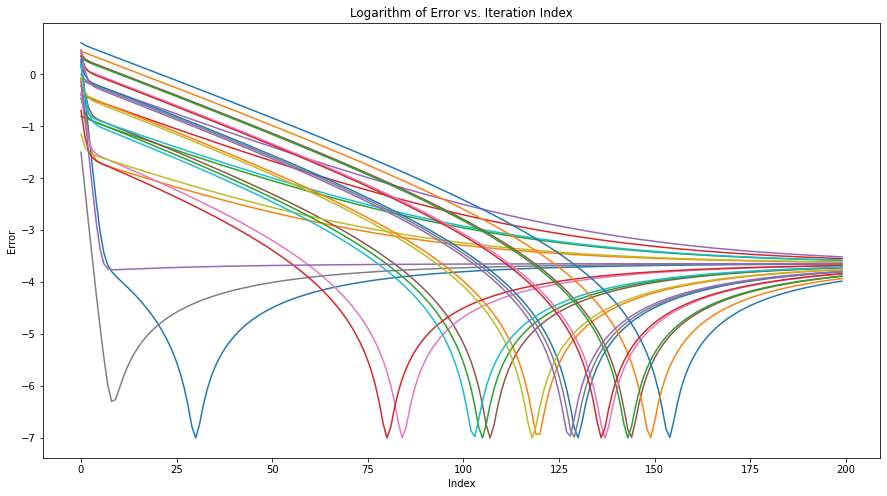

In [13]:
result['fig_3d'] = plot_error(result['grid_3c'])

## (2e)

The `plot_quiver` function creates an image of the $\nabla_\theta J$ as a vector field and returns the figure handle. 

The `plot_traj` function takes the existing figure handle as input (provided by `plot_quiver`) and should overlay it with the 25 trajectories obtained with gradient descent. Each trajectory should be plotted with a thin red line. `plot_traj` should then return the same figure handle. 

In [14]:
def plot_quiver():
    
    gridN = 10
    theta0_grid, theta1_grid = make_grid(gridN)
    flatgrid = np.reshape([theta0_grid, theta1_grid],(2,gridN**2)).T
    UV = np.empty(flatgrid.shape)
    for i, (theta0z, theta1z) in enumerate(flatgrid):
        UV[i,:] = nablaJ(XYsamp,theta0z, theta1z)
    
    fig = plt.figure(figsize=(8,8))
    plt.quiver(flatgrid[:,0], flatgrid[:,1],-UV[:,0],-UV[:,1],scale=30)
    
    plt.xlabel('theta0',fontsize=15)
    plt.ylabel('theta1',fontsize=15)
    plt.plot(theta0,theta1,'o',markersize=30)
    plt.axis([-1,1,-1,1])
    return fig

In [15]:
def plot_traj(fig,trajectories):  
    plt.figure(fig)
       
    gridN = trajectories.shape[0]
    
    for i in range(gridN):
        for j in range(gridN):
            
            plt.plot(trajectories[i, j, 0, 0], trajectories[i, j, 0, 1], 'go', markersize = 10)
            plt.plot(trajectories[i, j, -1, 0], trajectories[i, j, -1, 1], 'bo', markersize = 10)
            plt.plot(trajectories[i, j, :, 0], trajectories[i, j, :, 1], 'r-')
    
    return fig

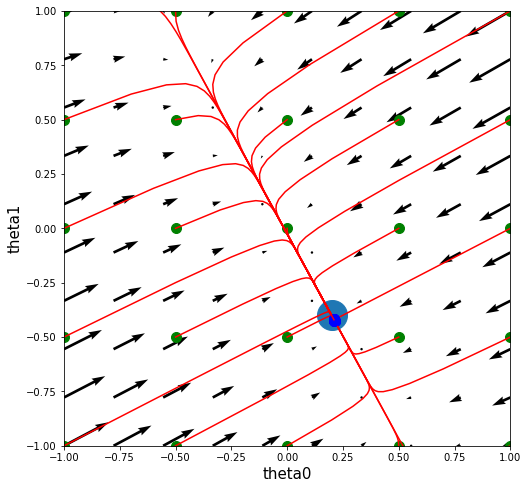

In [16]:
result['fig_3e'] = plot_traj(plot_quiver(),result['grid_3c'])

## (2f)

Repeat parts (d) and (e) with $\gamma=0.01$ and $\gamma=0.7$. 

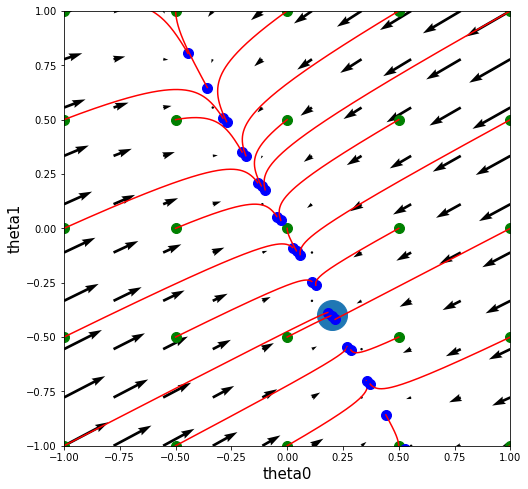

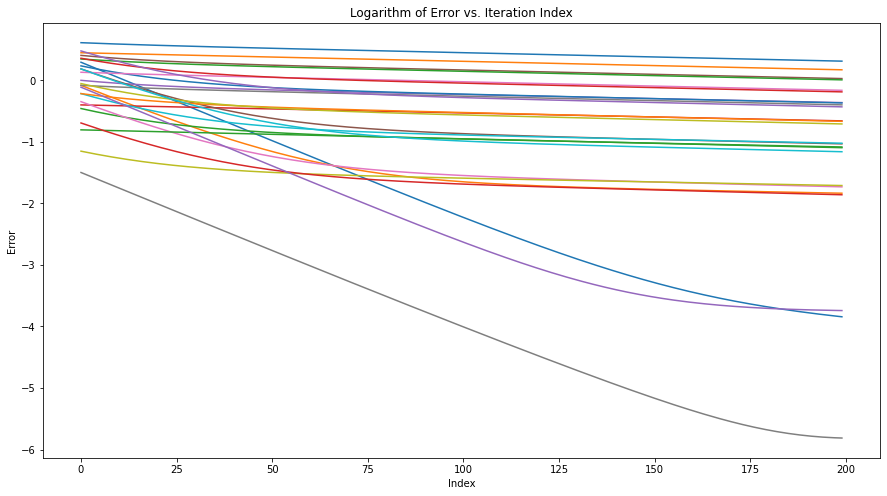

In [17]:
trajectories2 = run_gd_on_grid(theta0_grid,theta1_grid ,K=200,gamma=0.01)
result['fig_3fA_phase'] = plot_traj(plot_quiver(),trajectories2)
result['fig_3fA_error'] = plot_error(trajectories2)

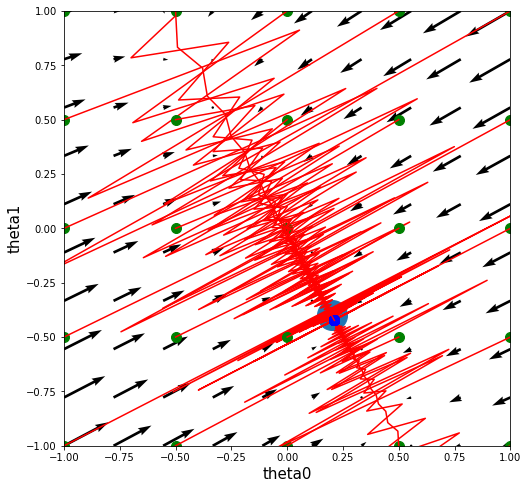

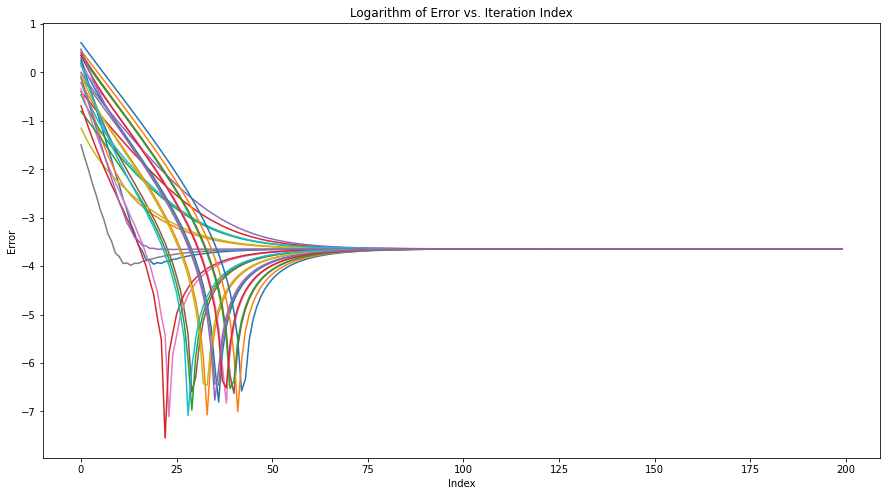

In [18]:
trajectories3 = run_gd_on_grid(theta0_grid,theta1_grid ,K=200,gamma=0.7)
result['fig_3fB_phase'] = plot_traj(plot_quiver(),trajectories3)
result['fig_3fB_error'] = plot_error(trajectories3)

# 3. Additive cost

For this part we will create a single plot in the $\theta_0, \theta_1$ plane. The limits should be from -1 to 1 along both axes, as in previous parts. The plot should have these elements. 

+ For each sample $n$, draw a thin black line in the parameter space corresponding to $\ell_n=0$. There should be a total of $N=40$ lines. 
+ Place a small dot at the intersection of every line. There will be a total of $N(N-1)/2$ such dots. Briefly explain the interpretation of these intersections. 
+ Plot a large dot at the location of the true parameter values. 
+ Overylay one of the gradient descent trajectories from part 2.


In [19]:
def plot_add_cst(): 
    # Draw x and y from XYsamp
    x = XYsamp[:, 0]
    y = XYsamp[:, 1]

    # Plot N zero-loss lines for each sample
    theta_1 = np.linspace(-1, 1, 100)

    for i in range(XYsamp.shape[0]):
        theta_0 = - x[i] * theta_1 + y[i]
        plt.plot(theta_1, theta_0, 'k-', linewidth = 0.2)

    # Find and save the intersection points
    intersec_pts = []
    for i in range(XYsamp.shape[0] - 1):
        for j in range(i + 1, XYsamp.shape[0]):
            intersec_pt0 = (x[i] * y[j] - x[j] * y[i]) / (x[i] - x[j])
            intersec_pt1 = (y[i] - y[j]) / (x[i] - x[j])
            intersec_pts.append([intersec_pt0, intersec_pt1])

    intersec_pts = np.asarray(intersec_pts)

    # Plot the intersection points
    plt.scatter(intersec_pts[:, 1], intersec_pts[:, 0], s = 5, color = 'k', label = 
                'Parameter values which can give zero loss for two different data points. ')

    # Plot the true parameter values
    plt.scatter(theta1, theta0, s = 500, color = 'k')

    return

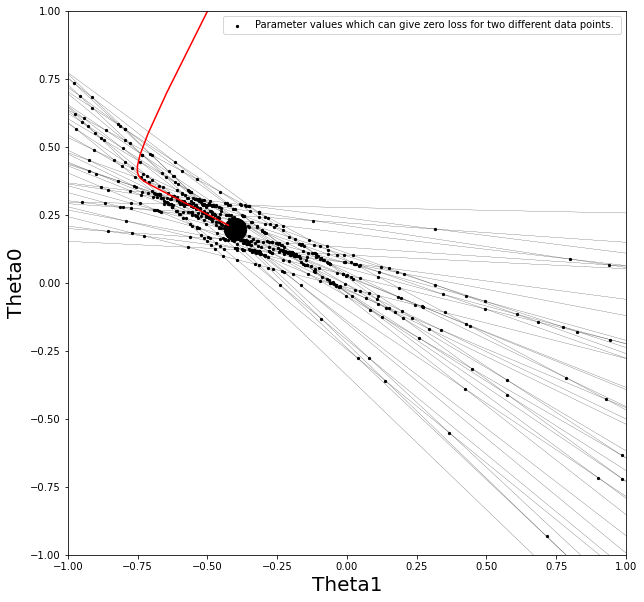

In [20]:
fig4 = plt.figure(figsize = (10, 10))

plot_add_cst()

# Pick up a random gradient descent trajectory and plot it
np.random.seed(42)
n1 = int(np.random.uniform(0, 4.9, 1))
n2 = int(np.random.uniform(0, 4.9, 1))

rand_traj = result['grid_3c'][n1, n2]

plt.plot(rand_traj[:, 1], rand_traj[:, 0], 'r-')

plt.axis([-1, 1, -1, 1])
plt.xlabel('Theta1', size = 20)
plt.ylabel('Theta0', size = 20)
plt.legend()
plt.show()

# 4. Stochastic Gradient Descent

## 4(a)

Code stochastic gradient descent. We will write a function `SGD`. This function takes as arguments 
+ the dataset `XYsamp`, 
+ the step size $\gamma$ and 
+ the number of epochs to run. 

`SGD` function should

+ randomly choose the initial condition with uniform probability from $[-1,1]\times[-1,1]$
+ use batches of size 1,
+ draw samples without replacement.

The function should return the parameter trajectory. 


Run SGD with $\gamma=0.1$ and 10 epochs. Recreate the plot from part 4 but using this SGD trajectory instead of GD. 

In [21]:
def SGD(XYsamp, gamma, epochs):
    N = XYsamp.shape[0]
    M = XYsamp.shape[1]
    SGD_traj = np.empty((epochs * N + 1, M))
    
    # Set up the random initial condition
    np.random.seed(42)
    SGD_traj[0, :] = np.random.uniform(-1, 1, M)
    
    for i in range(epochs):
        for j in range(N): 
            theta0 = SGD_traj[i*N + j, 0]
            theta1 = SGD_traj[i*N + j, 1]
            SGD_traj[i*N + j + 1, 0] = theta0 - gamma * 2 * (theta0 + theta1 * XYsamp[j,0] - XYsamp[j,1])
            SGD_traj[i*N + j + 1, 1] = theta1 - gamma * 2 * (theta0 + theta1 * XYsamp[j,0] - XYsamp[j,1]) * XYsamp[j,0]
            
    return SGD_traj

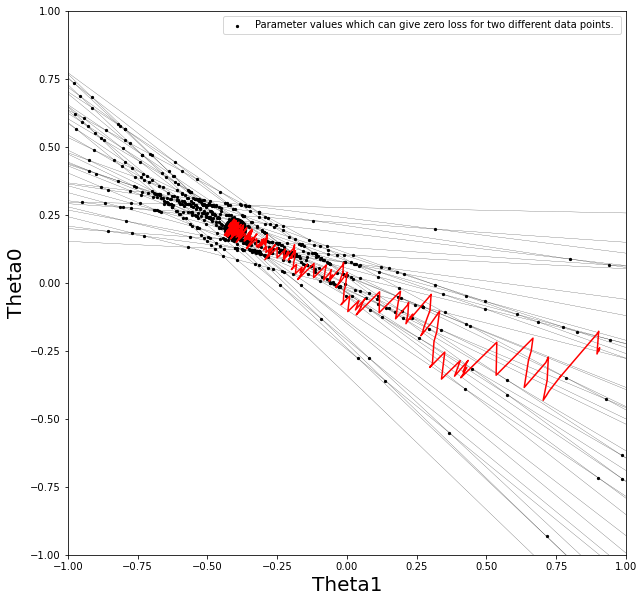

In [22]:
fig5a = plt.figure(figsize = (10, 10))

plot_add_cst()

# Compute SGD trajectory and plot

gamma = 0.1
epochs = 10

SGD_traj = SGD(XYsamp, gamma, epochs)

plt.plot(SGD_traj[:, 1], SGD_traj[:, 0], 'r-')

plt.axis([-1, 1, -1, 1])
plt.xlabel('Theta1', size = 20)
plt.ylabel('Theta0', size = 20)
plt.legend()
plt.show()

## 4(b)

Make the same plot with $\gamma=0.01$ and $\gamma=0.4$. 

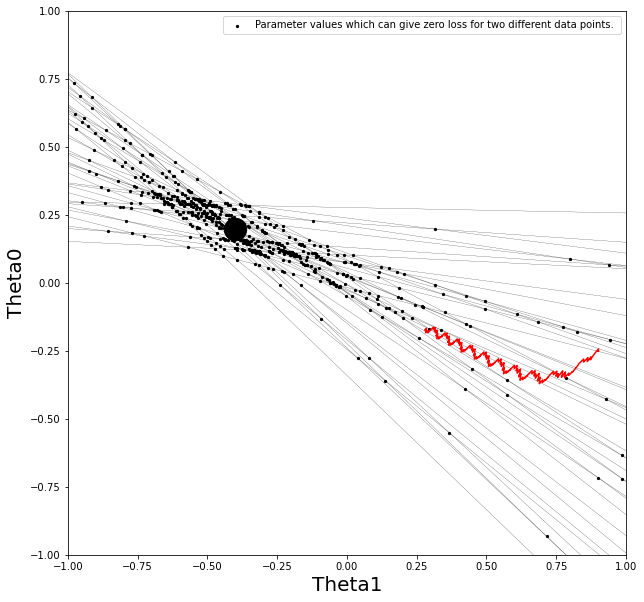

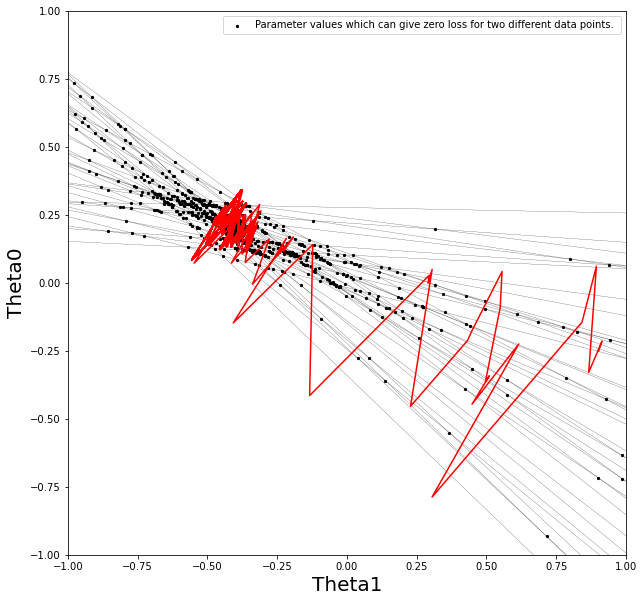

In [23]:
fig5b1 = plt.figure(figsize = (10, 10))

plot_add_cst()

SGD_traj = SGD(XYsamp, 0.01, 10)

plt.plot(SGD_traj[:, 1], SGD_traj[:, 0], 'r-')

plt.axis([-1, 1, -1, 1])
plt.xlabel('Theta1', size = 20)
plt.ylabel('Theta0', size = 20)
plt.legend()
plt.show()

fig5b2 = plt.figure(figsize = (10, 10))

plot_add_cst()

SGD_traj = SGD(XYsamp, 0.4, 10)

plt.plot(SGD_traj[:, 1], SGD_traj[:, 0], 'r-')

plt.axis([-1, 1, -1, 1])
plt.xlabel('Theta1', size = 20)
plt.ylabel('Theta0', size = 20)
plt.legend()
plt.show()